In [11]:
pip install zxcvbn

In [12]:
import re
import math

def analyze_password_basic(password):
    """
    Basic strength analysis
    """
    score = 0
    weaknesses = []

    # Length check
    if len(password) < 8:
        weaknesses.append("Too short (< 8 chars)")
    else:
        score += min(len(password) * 2, 20)  # Max 20 points for length

    # Character variety
    if re.search(r'[a-z]', password):
        score += 10
    else:
        weaknesses.append("No lowercase letters")

    if re.search(r'[A-Z]', password):
        score += 10
    else:
        weaknesses.append("No uppercase letters")

    if re.search(r'[0-9]', password):
        score += 10
    else:
        weaknesses.append("No numbers")

    if re.search(r'[!@#$%^&*(),.?":{}|<>]', password):
        score += 15
    else:
        weaknesses.append("No special characters")

    # Common patterns
    common_patterns = ['123', 'abc', 'qwer', 'pass', 'admin']
    for pattern in common_patterns:
        if pattern.lower() in password.lower():
            weaknesses.append(f"Contains common pattern: {pattern}")
            score -= 15

    # Dictionary words (simple check)
    common_words = ['password', 'admin', 'user', 'login', '12345']
    if password.lower() in common_words:
        weaknesses.append("Common dictionary word!")
        score = 0

    return max(score, 0), weaknesses

# Test it
test_passwords = [
    'password123',
    'P@ssw0rd!',
    'Tr0ub4dor&3',
    'correcthorsebatterystaple',
    'aB3#xK9$mQ2@'
]

for pwd in test_passwords:
    score, weak = analyze_password_basic(pwd)
    print(f"\nPassword: {pwd}")
    print(f"Score: {score}/100")
    print(f"Weaknesses: {weak if weak else 'None!'}")


Password: password123
Score: 10/100
Weaknesses: ['No uppercase letters', 'No special characters', 'Contains common pattern: 123', 'Contains common pattern: pass']

Password: P@ssw0rd!
Score: 63/100
Weaknesses: None!

Password: Tr0ub4dor&3
Score: 65/100
Weaknesses: None!

Password: correcthorsebatterystaple
Score: 30/100
Weaknesses: ['No uppercase letters', 'No numbers', 'No special characters']

Password: aB3#xK9$mQ2@
Score: 65/100
Weaknesses: None!


In [13]:
import re
import math

def analyze_password_complete(password):
    """
    Comprehensive password analysis: Strength, Crack Time, and Entropy.
    """
    if not password:
        return 0, ["Empty password"], "0 seconds", "NOT RATED", 0

    # 1. CHARACTER SET IDENTIFICATION
    charset_size = 0
    found_types = {
        "lowercase": (r'[a-z]', 26),
        "uppercase": (r'[A-Z]', 26),
        "digits": (r'[0-9]', 10),
        "special": (r'[!@#$%^&*(),.?":{}|<>]', 32)
    }

    active_types = []
    for name, (pattern, size) in found_types.items():
        if re.search(pattern, password):
            charset_size += size
            active_types.append(name)

    # 2. ENTROPY CALCULATION (Using math)
    # Formula: E = log2(charset_size ^ length)
    length = len(password)
    entropy = length * math.log2(charset_size) if charset_size > 0 else 0

    # 3. SCORE & WEAKNESSES (Heuristic)
    score = 0
    weaknesses = []

    # Length Weighting
    if length < 8:
        weaknesses.append("Too short")
    else:
        score += min(length * 3, 30) # More weight on length

    # Variety Bonus
    score += (len(active_types) * 10)

    # Common Patterns (Negative scoring)
    common_patterns = ['123', 'abc', 'qwer', 'pass', 'admin']
    for pattern in common_patterns:
        if pattern.lower() in password.lower():
            score -= 20
            weaknesses.append(f"Common pattern: {pattern}")

    # 4. CRACK TIME ESTIMATION
    # 1 Billion attempts per second (Modern GPU/Server cluster)
    attempts_per_second = 1_000_000_000
    total_combinations = charset_size ** length
    seconds_to_crack = total_combinations / (2 * attempts_per_second)

    # Human Readable Conversion
    if seconds_to_crack < 1:
        time_str, rating = "Instant", "💀 INSTANT"
    elif seconds_to_crack < 3600:
        time_str, rating = f"{seconds_to_crack/60:.2f} mins", "💀 VERY WEAK"
    elif seconds_to_crack < 31536000:
        time_str, rating = f"{seconds_to_crack/86400:.2f} days", "⚠️ MODERATE"
    elif seconds_to_crack < 31536000 * 100:
        time_str, rating = f"{seconds_to_crack/31536000:.2f} years", "✅ STRONG"
    else:
        time_str, rating = "Centuries", "🔒 EXCELLENT"

    return {
        "score": max(min(score, 100), 0),
        "entropy": round(entropy, 2),
        "crack_time": time_str,
        "rating": rating,
        "weaknesses": weaknesses
    }

# --- TEST SUITE ---
test_passwords = [
    'password123',
    'Tr0ub4dor&3',
    'correcthorsebatterystaple',
    'aB3#xK9$mQ2@'
]

print(f"{'Password':<28} | {'Score':<5} | {'Entropy':<8} | {'Crack Time':<12} | {'Rating'}")
print("-" * 80)
for pwd in test_passwords:
    res = analyze_password_complete(pwd)
    print(f"{pwd:<28} | {res['score']:<5} | {res['entropy']:<8} | {res['crack_time']:<12} | {res['rating']}")

Password                     | Score | Entropy  | Crack Time   | Rating
--------------------------------------------------------------------------------
password123                  | 10    | 56.87    | 2.09 years   | ✅ STRONG
Tr0ub4dor&3                  | 70    | 72.1     | Centuries    | 🔒 EXCELLENT
correcthorsebatterystaple    | 40    | 117.51   | Centuries    | 🔒 EXCELLENT
aB3#xK9$mQ2@                 | 70    | 78.66    | Centuries    | 🔒 EXCELLENT


In [14]:
def check_predictability(password):
    """
    Check for common human behavioral patterns in passwords.
    """
    predictability_warnings = []

    # 1. Leetspeak detection
    leetspeak_map = {'@': 'a', '0': 'o', '1': 'i', '3': 'e', '$': 's', '7': 't'}
    transformed = password.lower()
    for char, replacement in leetspeak_map.items():
        transformed = transformed.replace(char, replacement)

    # If the transformed version is a common word, it's a weak substitution
    common_words = ['password', 'admin', 'login', 'secret']
    if transformed in common_words and password.lower() != transformed:
        predictability_warnings.append("Predictable leetspeak substitution detected")

    # 2. Sequential characters (e.g., abc, 123)
    if any(password[i:i+3].lower() in "abcdefghijklmnopqrstuvwxyz0123456789"
           for i in range(len(password)-2)):
        predictability_warnings.append("Sequential characters detected (e.g., 'abc' or '123')")

    # 3. Case Patterns
    if re.match(r'^[A-Z][a-z]+[!0-9]$', password):
        predictability_warnings.append("Standard pattern detected (Capital + lowercase + number/symbol)")

    return predictability_warnings

In [15]:
from collections import Counter

def detect_patterns(password):
    """
    Detect common patterns that make passwords weaker
    """
    patterns_found = []

    # Keyboard walks (qwerty, asdfgh, etc.)
    keyboard_patterns = [
        'qwerty', 'asdfgh', 'zxcvbn',
        'qwertz', 'asdfghjkl',  # German keyboard
        '12345', '09876'
    ]
    for pattern in keyboard_patterns:
        if pattern in password.lower():
            patterns_found.append(f"Keyboard walk: {pattern}")

    # Leet speak detection (e -> 3, a -> @, o -> 0)
    leet_map = {'3': 'e', '@': 'a', '0': 'o', '1': 'i', '$': 's'}
    unleet_password = password
    for leet, normal in leet_map.items():
        unleet_password = unleet_password.replace(leet, normal)

    common_words = ['password', 'admin', 'letmein', 'welcome', 'monkey']
    if unleet_password.lower() in common_words:
        patterns_found.append(f"Leet-speak disguised word: {unleet_password}")

    # Repeated characters
    for char in set(password):
        if password.count(char) > 2:
            patterns_found.append(f"Repeated char: '{char}' appears {password.count(char)} times")
            # Refined Repeated characters (Consecutive)
    if re.search(r'(.)\1\1', password):  # Matches any char repeated 3+ times in a row
        patterns_found.append("Consecutive repeating characters (e.g., 'aaa')")

    # Sequential numbers
    if re.search(r'(012|123|234|345|456|567|678|789)', password):
        patterns_found.append("Sequential numbers detected")

    # Year patterns (1990-2025)
    if re.search(r'(19[0-9]{2}|20[0-2][0-9])', password):
        patterns_found.append("Possible birth year detected")

    return patterns_found

# Test
for pwd in test_passwords:
    patterns = detect_patterns(pwd)
    print(f"\nPassword: {pwd}")
    print(f"Patterns: {patterns if patterns else 'None detected'}")


Password: password123
Patterns: ['Sequential numbers detected']

Password: Tr0ub4dor&3
Patterns: None detected

Password: correcthorsebatterystaple
Patterns: ["Repeated char: 'r' appears 4 times", "Repeated char: 'e' appears 4 times", "Repeated char: 't' appears 4 times"]

Password: aB3#xK9$mQ2@
Patterns: None detected


In [16]:
import re
import math
import random
from collections import Counter

# --- MODULE 1: The Math & Strength ---
def calculate_metrics(password):
    # (Your crack time and entropy logic)
    charset_size = 0
    if re.search(r'[a-z]', password): charset_size += 26
    if re.search(r'[A-Z]', password): charset_size += 26
    if re.search(r'[0-9]', password): charset_size += 10
    if re.search(r'[!@#$%^&*(),.?":{}|<>]', password): charset_size += 32

    entropy = len(password) * math.log2(charset_size) if charset_size > 0 else 0

    attempts_per_second = 1_000_000_000
    total_combinations = charset_size ** len(password)
    seconds_to_crack = total_combinations / (2 * attempts_per_second)

    return entropy, seconds_to_crack

# --- MODULE 2: The Pattern Hunter ---
def find_weaknesses(password):
    # (Your detect_patterns logic)
    found = []
    if len(password) < 8: found.append("Too short")

    # Check for keyboard walks, years, and leet-speak
    if re.search(r'(19[0-9]{2}|20[0-2][0-9])', password):
        found.append("Possible birth year detected")

    # Repeated characters (Consecutive)
    if re.search(r'(.)\1\1', password):
        found.append("Consecutive repeating characters")

    return found

# --- MODULE 3: The AI Simulator ---
def simulate_attack(password):
    # (Your ai_password_guesser logic)
    common = ['password123', 'admin', '123456']
    for i, guess in enumerate(common, 1):
        if guess == password.lower():
            return i, "Common Dictionary Attack"
    return None, None

# --- FINAL WRAPPER: The Security Report ---
def run_full_security_audit(password):
    entropy, seconds = calculate_metrics(password)
    weaknesses = find_weaknesses(password)
    crack_idx, crack_method = simulate_attack(password)

    print(f"\n--- SECURITY AUDIT: {password} ---")
    print(f"Entropy: {entropy:.2f} bits")
    print(f"Status: {'💀 CRACKED' if crack_idx else '🔒 SECURE'}")

    if crack_idx:
        print(f"AI Success: Found via {crack_method} in {crack_idx} attempts.")

    if weaknesses:
        print(f"Weaknesses Found: {', '.join(weaknesses)}")

    print(f"Brute Force Est: {seconds:.2e} seconds")

# TEST IT
run_full_security_audit("password123")
run_full_security_audit("Tr0ub4dor&3")


--- SECURITY AUDIT: password123 ---
Entropy: 56.87 bits
Status: 💀 CRACKED
AI Success: Found via Common Dictionary Attack in 1 attempts.
Brute Force Est: 6.58e+07 seconds

--- SECURITY AUDIT: Tr0ub4dor&3 ---
Entropy: 72.10 bits
Status: 🔒 SECURE
Brute Force Est: 2.53e+12 seconds


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import re # Ensure re is available inside the function context

def visualize_password_strength(password):
    # Call your previous modules
    score, weaknesses = analyze_password_basic(password)
    time_str, rating = calculate_crack_time(password)
    patterns = detect_patterns(password)

    # 1. SETUP THE DASHBOARD
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    fig.patch.set_facecolor('#f0f0f0') # Light grey background for professional look
    fig.suptitle(f'Password Security Audit: {"*" * len(password)}', fontsize=20, fontweight='bold')

    # 2. OVERALL SCORE (Horizontal Gauge)
    color = 'crimson' if score < 40 else 'darkorange' if score < 75 else 'seagreen'
    ax1.barh(['Strength'], [score], color=color, height=0.6)
    ax1.set_xlim(0, 100)
    ax1.set_title('Security Rating', fontsize=14)
    ax1.text(score + 2, 0, f'{score}/100', va='center', fontsize=16, fontweight='bold')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # 3. CRACK TIME BOX
    ax2.set_facecolor('white')
    ax2.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=True, color='white', alpha=0.1, transform=ax2.transAxes))
    ax2.text(0.5, 0.5, f"ESTIMATED CRACK TIME\n\n{time_str.upper()}\n\nRating: {rating}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor=color, boxstyle='round,pad=1'))
    ax2.axis('off')

    # 4. PIE CHART (Character Variety)
    counts = [len(re.findall(r'[a-z]', password)), len(re.findall(r'[A-Z]', password)),
              len(re.findall(r'[0-9]', password)), len(re.findall(r'[^a-zA-Z0-9]', password))]
    labels = ['abc', 'ABC', '123', '#&!']
    # Only plot if count > 0 to keep the pie clean
    final_counts = [c for c in counts if c > 0]
    final_labels = [l for c, l in zip(counts, labels) if c > 0]

    ax3.pie(final_counts, labels=final_labels, autopct='%1.0f%%', startangle=140,
            colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], wedgeprops={'edgecolor': 'white'})
    ax3.set_title('Complexity Mix', fontsize=14)

    # 5. WEAKNESSES & ALERTS
    ax4.axis('off')
    alert_text = "⚠️ AUDIT FINDINGS\n" + "-"*20 + "\n"
    all_issues = weaknesses + patterns
    if not all_issues:
        alert_text += "✅ Perfect Score! No issues found."
    else:
        for issue in all_issues[:6]: # Limit to top 6 to prevent overflow
            alert_text += f"• {issue}\n"

    ax4.text(0.05, 0.5, alert_text, fontsize=12, va='center', family='monospace',
             bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=1'))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

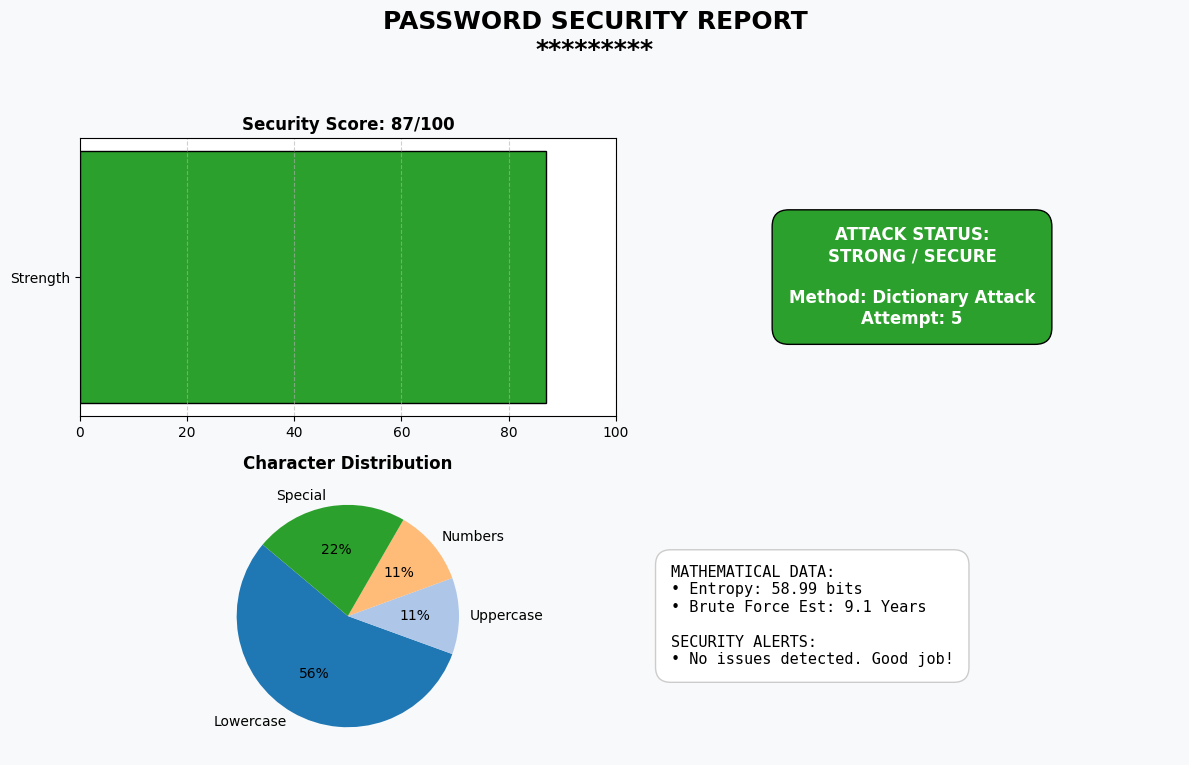

In [18]:
import re
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ==========================================
# MODULE 1: CORE ANALYSIS & MATH
# ==========================================
def analyze_password_metrics(password):
    """Calculates basic score, entropy, and character counts."""
    score = 0
    weaknesses = []

    # 1. Length Check
    length = len(password)
    if length < 8:
        weaknesses.append("Length: Too short (< 8 chars)")
    else:
        score += min(length * 3, 30)

    # 2. Character Variety & Counts
    chars = {
        'lowercase': (len(re.findall(r'[a-z]', password)), 26),
        'uppercase': (len(re.findall(r'[A-Z]', password)), 26),
        'numbers': (len(re.findall(r'[0-9]', password)), 10),
        'special': (len(re.findall(r'[^a-zA-Z0-9]', password)), 32)
    }

    pool_size = 0
    for name, (count, size) in chars.items():
        if count > 0:
            score += 15
            pool_size += size
        else:
            weaknesses.append(f"Missing: {name}")

    # 3. Entropy (using math)
    entropy = length * math.log2(pool_size) if pool_size > 0 else 0

    # 4. Crack Time (1 Billion attempts/sec)
    total_combos = pool_size ** length if pool_size > 0 else 0
    seconds = total_combos / (2 * 1_000_000_000)

    return {
        "score": max(min(score, 100), 0),
        "entropy": round(entropy, 2),
        "seconds": seconds,
        "counts": {k: v[0] for k, v in chars.items()},
        "weaknesses": weaknesses,
        "pool_size": pool_size
    }

# ==========================================
# MODULE 2: PATTERN & BEHAVIOR DETECTION
# ==========================================
def detect_behavioral_patterns(password):
    """Detects keyboard walks, years, and leet-speak."""
    patterns = []

    # Keyboard walks
    walks = ['qwerty', 'asdfgh', 'zxcvbn', '123456']
    if any(w in password.lower() for w in walks):
        patterns.append("Keyboard walk detected")

    # Years
    if re.search(r'(19[0-9]{2}|20[0-2][0-9])', password):
        patterns.append("Possible birth year/date")

    # Leet-speak normalization
    leet = {'3':'e', '@':'a', '0':'o', '1':'i', '$':'s'}
    normalized = password.lower()
    for k, v in leet.items(): normalized = normalized.replace(k, v)
    if normalized in ['password', 'admin', 'welcome', 'monkey']:
        patterns.append("Common word disguised as leet-speak")

    return patterns

# ==========================================
# MODULE 3: AI ATTACK SIMULATOR
# ==========================================
def simulate_ai_attack(password):
    """Simulates a targeted dictionary and rule-based attack."""
    # Simplified dictionary for simulation
    dictionary = ['password123', 'Password123', 'admin', '123456', 'P@ssw0rd!']
    for attempt, guess in enumerate(dictionary, 1):
        if guess == password:
            return True, attempt, "Dictionary Attack"
    return False, 0, None

# ==========================================
# MODULE 4: THE VISUALIZER (FRONTEND)
# ==========================================
def run_security_audit(password):
    # Get Data from previous modules
    metrics = analyze_password_metrics(password)
    patterns = detect_behavioral_patterns(password)
    cracked, attempts, method = simulate_ai_attack(password)

    # Time formatting for humans
    if metrics['seconds'] > 31536000:
        time_str = f"{metrics['seconds']/31536000:.1f} Years"
    elif metrics['seconds'] > 86400:
        time_str = f"{metrics['seconds']/86400:.1f} Days"
    else:
        time_str = f"{metrics['seconds']:.1f} Seconds"

    # Define dynamic colors based on score
    if metrics['score'] < 50:
        color_theme = '#d62728' # Security Red
        status_label = "CRITICAL / CRACKED" if cracked else "WEAK"
    elif metrics['score'] < 80:
        color_theme = '#ff7f0e' # Security Orange
        status_label = "MODERATE"
    else:
        color_theme = '#2ca02c' # Security Green
        status_label = "STRONG / SECURE"

    # Setup Figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    fig.patch.set_facecolor('#f8f9fa')
    fig.suptitle(f"PASSWORD SECURITY REPORT\n{'*' * len(password)}", fontsize=18, fontweight='bold')

    # 1. Strength Gauge (Bar)
    ax1.barh(['Strength'], [metrics['score']], color=color_theme, edgecolor='black')
    ax1.set_xlim(0, 100)
    ax1.set_title(f"Security Score: {metrics['score']}/100", fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.6)

    # 2. AI Crack Status (Text Box)
    display_text = f"ATTACK STATUS:\n{status_label}"
    if cracked:
        display_text += f"\n\nMethod: {method}\nAttempt: {attempts}"

    ax2.text(0.5, 0.5, display_text, ha='center', va='center',
             fontsize=12, fontweight='bold', color='white',
             bbox=dict(facecolor=color_theme, edgecolor='black', boxstyle='round,pad=1'))
    ax2.axis('off')

    # 3. Composition Pie
    labels = [k.capitalize() for k,v in metrics['counts'].items() if v > 0]
    values = [v for v in metrics['counts'].values() if v > 0]
    if values:
        ax3.pie(values, labels=labels, autopct='%1.0f%%', startangle=140,
                colors=['#1f77b4', '#aec7e8', '#ffbb78', '#2ca02c'])
    ax3.set_title("Character Distribution", fontweight='bold')

    # 4. Summary & Alerts
    summary = f"MATHEMATICAL DATA:\n"
    summary += f"• Entropy: {metrics['entropy']} bits\n"
    summary += f"• Brute Force Est: {time_str}\n\n"
    summary += "SECURITY ALERTS:\n"

    all_issues = metrics['weaknesses'] + patterns
    if not all_issues:
        summary += "• No issues detected. Good job!"
    else:
        for issue in all_issues[:5]:
            summary += f"• {issue}\n"

    ax4.text(0.05, 0.5, summary, fontsize=11, va='center', family='monospace',
             bbox=dict(facecolor='white', edgecolor='#cccccc', boxstyle='round,pad=1'))
    ax4.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# RUN TEST
# ==========================================
run_security_audit("P@ssw0rd!")

In [19]:
import re
import math
import random
import string
import getpass
import sys
from zxcvbn import zxcvbn  # The "RockYou" smart dictionary engine

# 1. THE CORE STRENGTH ANALYZER
def analyze_password_basic(password):
    score = 0
    weaknesses = []
    if len(password) < 8:
        weaknesses.append("Too short (< 8 chars)")
    else:
        score += min(len(password) * 2, 20)

    if re.search(r'[a-z]', password): score += 10
    if re.search(r'[A-Z]', password): score += 10
    if re.search(r'[0-9]', password): score += 10
    if re.search(r'[!@#$%^&*(),.?":{}|<>]', password): score += 15

    common_patterns = ['123', 'abc', 'qwer', 'pass', 'admin']
    for pattern in common_patterns:
        if pattern.lower() in password.lower():
            weaknesses.append(f"Contains common pattern: {pattern}")
            score -= 15

    return max(score, 0), weaknesses

# 2. THE CRACK TIME CALCULATOR (Mathematical Brute Force)
def calculate_crack_time(password):
    charset_size = 0
    if re.search(r'[a-z]', password): charset_size += 26
    if re.search(r'[A-Z]', password): charset_size += 26
    if re.search(r'[0-9]', password): charset_size += 10
    if re.search(r'[!@#$%^&*(),.?":{}|<>]', password): charset_size += 32

    if charset_size == 0 or len(password) == 0:
        return "0 seconds", "INSTANT"

    total_combinations = charset_size ** len(password)
    attempts_per_second = 1_000_000_000 # 1 GHz cracking speed
    seconds_to_crack = total_combinations / (2 * attempts_per_second)

    if seconds_to_crack < 60:
        return f"{seconds_to_crack:.2f} seconds", "INSTANT"
    elif seconds_to_crack < 31536000:
        return f"{seconds_to_crack/86400:.2f} days", "MODERATE"
    else:
        return f"{seconds_to_crack/31536000:.0f} years", "EXCELLENT"

# 3. THE AI GUESSER (Using zxcvbn for RockYou-style patterns)
def ai_password_guesser(target_password):
    # zxcvbn checks common leaked passwords (like RockYou), names, and dates
    results = zxcvbn(target_password)
    score = results['score'] # 0-4 scale
    feedback = results['feedback']['warning']

    if score < 3:
        return True, f"Matched common pattern/leak: {feedback if feedback else 'Commonly used password'}"
    return False, "Resisted smart dictionary attacks!"

# 4. THE PASSWORD HARDENER
def harden_password(base_password):
    random_suffix = ''.join(random.choices(string.ascii_letters + string.digits + "!@#$", k=4))
    hardened = base_password.capitalize()
    substitutions = {'a': '@', 's': '$', 'e': '3', 'i': '1', 'o': '0'}
    for char, sub in substitutions.items():
        if char in hardened.lower():
            hardened = hardened.replace(char, sub, 1)
    return f"{hardened}_{random_suffix}"

# 5. THE INTERACTIVE GAME
def password_challenge():
    print("\n" + "="*40)
    print("       🛡️  PASSWORD CHALLENGE 🛡️")
    print("="*40)
    print("Type your password (it will be hidden if supported)...")

    try:
        if sys.stdin.isatty():
            user_password = getpass.getpass("Enter Password: ")
        else:
            user_password = input("Enter Password: ")
    except Exception:
        user_password = input("Enter Password: ")

    if not user_password:
        print("Error: No input received.")
        return

    # ANALYSIS
    score, weaknesses = analyze_password_basic(user_password)
    time_str, rating = calculate_crack_time(user_password)
    cracked, method = ai_password_guesser(user_password)

    # UNIFIED LOGIC: It's only secure if it's not cracked AND not mathematically weak
    is_mathematically_weak = "INSTANT" in rating or score < 40

    print(f"\nAUDIT REPORT FOR: {'*' * len(user_password)}")
    print(f"Brute Force Estimate: {time_str}")
    print("-" * 40)

    if cracked or is_mathematically_weak:
        print("RESULT: 💀 VULNERABLE")
        if cracked:
            print(f"Reason: {method}")
        else:
            print("Reason: Mathematically too simple for brute force.")

        print(f"\n💡 TRY THIS INSTEAD: {harden_password(user_password)}")
        if weaknesses:
            print("Tips for Improvement:")
            for w in weaknesses: print(f" • {w}")
    else:
        print("RESULT: 🔒 SECURE")
        print("Great work! You beat the dictionary and the math.")

    print("="*40 + "\n")

# START THE APP
if __name__ == "__main__":
    password_challenge()


       🛡️  PASSWORD CHALLENGE 🛡️
Type your password (it will be hidden if supported)...
Enter Password: All is fair in love and war

AUDIT REPORT FOR: ***************************
Brute Force Estimate: 340607083446611473077983248384 years
----------------------------------------
RESULT: 🔒 SECURE
Great work! You beat the dictionary and the math.

